# Plot figures analogue analysis (poster/presentation)

### Packages and Directories

In [5]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
from statsmodels.stats.multitest import fdrcorrection
import calendar
from datetime import datetime, timedelta
import cftime

from scipy import ndimage

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

In [6]:
# Define directories for data and figures
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
# fig_dir = '/home/portal/figures/analogues/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/poster/'
diff_dir = './analogue_data/analogue_differences/'
pr_mask_dir = './analogue_data/pr_in_mask/'

### Parameters

In [7]:
# Variable
var_analogues = 'psl'  # Variable used to find the analogues, e.g. 'psl' for sea level pressure

# Quantile and analogue number
qtl_LE = 0.99
no_analogues = 18

# Number of ensemble members
no_membs = 49

# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + 'psl') if os.path.isdir(os.path.join(CRCM5_dir + 'psl', name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members


In [8]:
# Event
lselect = 'alertregions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 3
no_event = 3
event_origin = 'CRCM5-LE'  # 'ERA5' or 'CRCM5-LE'
str_event_ERA5 = f'node{no_node}-extreme{no_event}-{lselect}'  # 'Italy' or 'wide-region' or 'alert-regions'
str_event_BAM = f'BAM-node{no_node}-extreme{no_event}-{lselect}'  # 'Italy' or 'wide-region' or 'alert-regions'

# ERA5
df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alertregions_CERRA.xlsx', sheet_name=no_node-1)
time_ERA5event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
doy_ERA5event =  time_ERA5event.timetuple().tm_yday

# BAM
BAM_info, BAM_index = fanPM.get_best_model_analogue_info(no_node, no_event, var_analogues)
time = datetime.strptime(BAM_info['date'][BAM_index], "%Y-%m-%d")
time_BAMevent = cftime.DatetimeNoLeap(time.year, time.month, time.day, hour=0, minute=0, second=0)
doy_BAMevent = time_BAMevent.timetuple().tm_yday
member_BAMevent = BAM_info['member'][BAM_index]

# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

# Defines the months for analogue selection
# ERA5
month_ERA5event = time_ERA5event.month
months_sel_ERA5 = [month_ERA5event-1, month_ERA5event, month_ERA5event+1]
month_names_ERA5 = [calendar.month_abbr[month] for month in months_sel_ERA5]
str_months_ERA5 = ''.join([name[0] for name in month_names_ERA5])
# BAM
month_BAMevent = time_BAMevent.month
months_sel_BAM = [month_BAMevent-1, month_BAMevent, month_BAMevent+1]
month_names_BAM = [calendar.month_abbr[month] for month in months_sel_BAM]
str_months_BAM = ''.join([name[0] for name in month_names_BAM])



### Plot event ERA5 (first row of figures) and BAM (second row of figures)

In [9]:
# Upload data ERA5

# mslp
dmslp_event_ERA5 = fanPM.load_ERA5_data('mslp', 'daily', time_ERA5event, box_event, l_anom=True, data_dir=ERA5_dir+'mslp/')
mslp_clim_ERA5 = fanPM.load_ERA5_clim('mslp', doy_ERA5event, box_event, l_smoothing=True, data_dir=ERA5_dir+'mslp/climatology/')
# Regrid 
dmslp_event_ERA5 = fanPM.regrid_with_xesmf(dmslp_event_ERA5, box_event, resolution=0.5)
mslp_clim_ERA5 = fanPM.regrid_with_xesmf(mslp_clim_ERA5, box_event, resolution=0.5)

# precip
precip_event_CERRA = fanPM.load_CERRA_precip(time_ERA5event-pd.Timedelta('18h'), box_event, data_dir=CERRA_dir+'precip/')

/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [10]:
# Upload data CRCM5
year_range_BAM = [2004,2023]
# psl
BAM_files, BAM_files_clim = fanPM.get_anomaly_climatology_paths_CRCM5_bymonth(CRCM5_dir, var_analogues, [member_BAMevent], [[time_BAMevent]])
list_ds = fanPM.open_member_datasets(BAM_files, combine='by_coords', expand_member_dim=True)
list_ds_clim = fanPM.open_member_datasets(BAM_files_clim, combine='by_coords', expand_member_dim=True)
dmslp_BAM = xr.concat(list_ds, dim='member')['psl'] * 0.01
mslp_BAM = xr.concat(list_ds_clim, dim='member')['psl'] * 0.01
# Select the time of the event
dmslp_BAM = dmslp_BAM.sel(time=time_BAMevent).squeeze('member')
doy_clim = mslp_BAM.time.dt.dayofyear.values
mask_time = doy_clim == doy_BAMevent
mslp_BAM = mslp_BAM.sel(time=mask_time).squeeze('time').squeeze('member')

# precip
precip_files = fanPM.get_precipitation_paths_CRCM5_bymonth(CRCM5_dir, [member_BAMevent], [[time_BAMevent]])
# Make list of datasets and add 'member' coordinate
list_ds = fanPM.open_member_datasets(precip_files, combine='by_coords', expand_member_dim=True)
# Concatenate, scale, choose date and select box
pr_tmp = xr.concat(list_ds, dim='member')['pr'] * 3600 # Convert from mm/s*24 to mm/day
pr_BAM = pr_tmp.sel(time=time_BAMevent + timedelta(hours=12)).squeeze('member')

# Select lon lat mask for the event
lon_mask, lat_mask = fanPM.lonlat_mask(dmslp_BAM.lon.values, dmslp_BAM.lat.values, box_event)
mask_BAM = lat_mask[:, np.newaxis] & lon_mask
mask_xr_BAM = xr.DataArray(
    mask_BAM,
    dims=["lat", "lon"],
    coords={"lat": dmslp_BAM.lat.values, "lon": dmslp_BAM.lon.values},
)

# Apply mask
dmslp_BAM = dmslp_BAM.where(mask_xr_BAM, drop=True)
mslp_BAM = mslp_BAM.where(mask_xr_BAM, drop=True)
pr_BAM = pr_BAM.where(mask_xr_BAM, drop=True)

Opening files for member: kbi
Opening files for member: kbi
Opening files for member: kbi


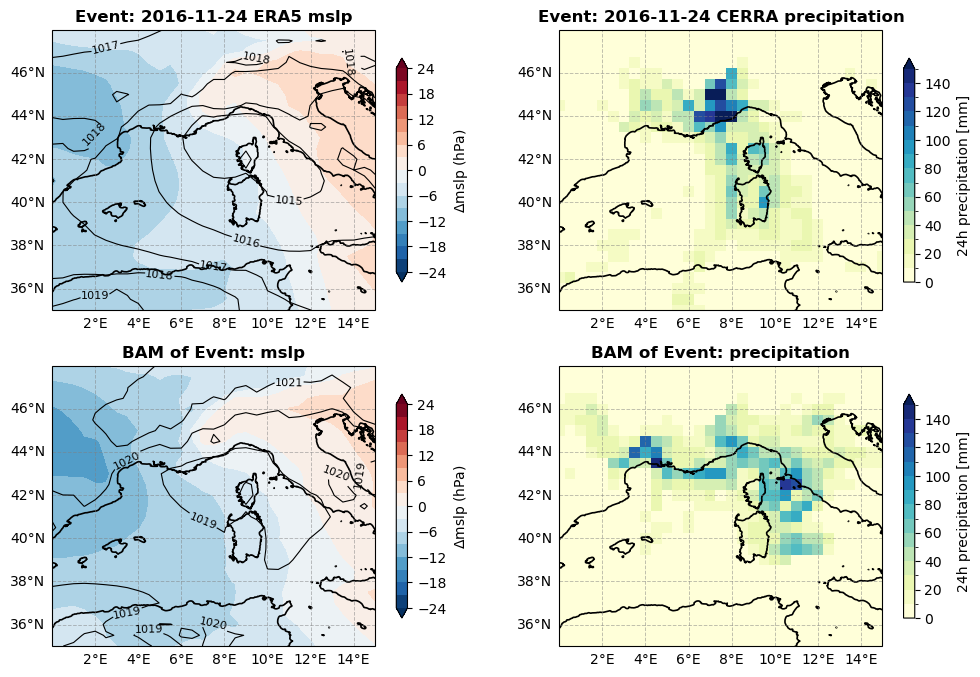

In [11]:
fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot ERA5 mslp
dmslp_levels = np.arange(-24,25,3)
fanPM.plot_anom_event(ax[0], 'mslp', dmslp_event_ERA5.lon, dmslp_event_ERA5.lat, dmslp_event_ERA5, mslp_clim_ERA5, f'Event: {time_ERA5event.strftime("%Y-%m-%d")} ERA5 mslp', levels=dmslp_levels)
fanPM.plot_anom_event(ax[2], 'mslp', dmslp_BAM.lon, dmslp_BAM.lat, dmslp_BAM, mslp_BAM, 'BAM of Event: mslp', levels=dmslp_levels)

# Plot BAM precipitation
fanPM.plot_precipitation(ax[1], box_event, precip_event_CERRA, 
                         precip_levels=np.arange(0, 155, 10), title=f'Event: {time_ERA5event.strftime("%Y-%m-%d")} CERRA precipitation')
timestr_BAMevent = str(pr_BAM.time.dt.strftime("%Y-%m-%d %H:%M UTC").values)[:10]
fanPM.plot_precipitation(ax[3], box_event, pr_BAM, 
                         precip_levels=np.arange(0, 155, 10), title='BAM of Event: precipitation')

# Save the figure
fig.savefig(f"{fig_dir}mslp_pr_BAM-{var_analogues}_node{no_node}_extreme{no_event}-alertregions_{str_months_ERA5}_{year_range_BAM[0]}-{year_range_BAM[1]}_CRCM5-LE_{no_membs}membs.png", bbox_inches='tight', dpi=300)

### Plot analogue mean in different epochs

In [12]:
# Variable
varname = 'tas'
if varname == 'psl':
    vartitle = 'mslp'
elif varname == 'tas':
    vartitle = 'tas'

# List epochs
list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
no_epochs = len(list_year_ranges)


In [13]:
# Upload analogue data
list_ds_anom = []  # List to store difference datasets
list_ds_clim = []  # List to store difference datasets
for i in range(no_epochs):
    year_range = list_year_ranges[i]
    str_year_range = "-".join(str(x) for x in year_range)
    suffix_file = f"_{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_{str_year_range}_CRCM5_{no_membs}membs.nc"
        
    # Load analogue anomalies
    anom_file = f'{diff_dir}analogues-{var_analogues}_anomaly{suffix_file}'
    if not os.path.exists(anom_file):
        print(f'File {anom_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_anom = xr.open_dataset(anom_file)
    list_ds_anom.append(ds_anom)

    # Load climatologies
    clim_file = f'{diff_dir}analogues-{var_analogues}_climatology{suffix_file}'
    if not os.path.exists(clim_file):
        print(f'File {clim_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_clim = xr.open_dataset(clim_file)
    list_ds_clim.append(ds_clim)

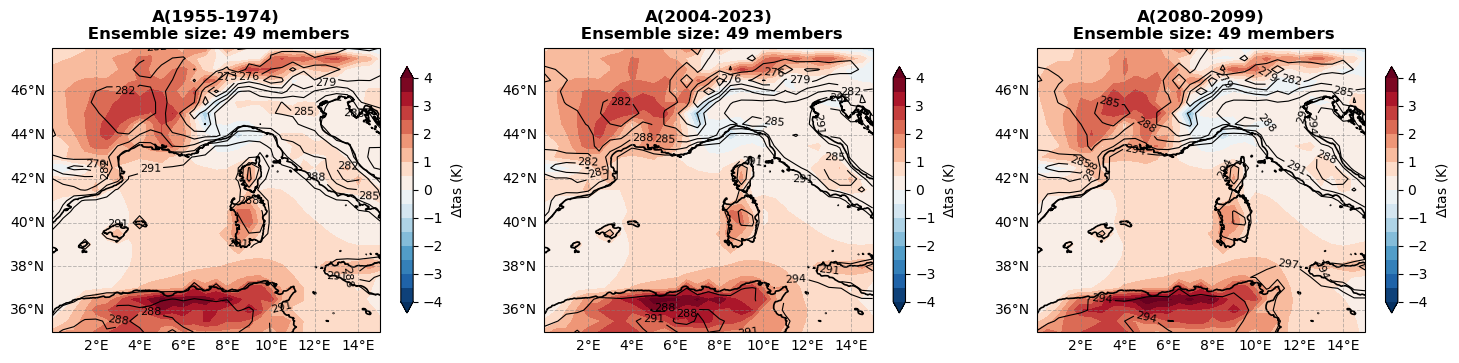

In [14]:
fig, ax = plt.subplots(
    nrows=1, ncols=no_epochs, figsize=(6*no_epochs, 4),
    sharey=True,
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot
if varname == 'psl':
    if no_node == 6 and no_event == 19:
        levels = np.arange(-10, 11, 1)
    elif no_node == 1 and no_event == 1:
        levels = np.arange(-18, 19, 1.5)
    elif no_node == 5 and no_event == 4:
        levels = np.arange(-10, 11, 1)
    elif no_node == 3 and no_event == 3:
        levels = np.arange(-10, 11, 1)
    
elif varname == 'tas':
    levels = np.arange(-4, 4.25, 0.5)
for i in range(no_epochs):
    fanPM.plot_anom_event(
        ax[i], vartitle, 
        list_ds_anom[i].lon, list_ds_anom[i].lat, 
        list_ds_anom[i][varname], list_ds_clim[i][varname], 
        f'A({list_year_ranges[i][0]}-{list_year_ranges[i][1]})\n Ensemble size: {no_membs} members',
        levels
    )
# fig.suptitle(f'Composites of BAM analogues ({no_membs} members)', fontsize=12, fontweight='bold')

# Save the figure
fig.savefig(f"{fig_dir}{varname}_analogue-anomalies-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)

In [13]:
# Variable
varname = 'pr'
factor = 3600

# List epochs
list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
no_epochs = len(list_year_ranges)


In [14]:
# Upload analogue data
list_ds = []  # List to store difference datasets
for i in range(no_epochs):
    year_range = list_year_ranges[i]
    str_year_range = "-".join(str(x) for x in year_range)
    suffix_file = f"{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_{str_year_range}_CRCM5_{no_membs}membs.nc"
        
    # Load analogue anomalies
    file = f'{diff_dir}analogues-{var_analogues}_{suffix_file}'
    if not os.path.exists(file):
        print(f'File {file} does not exist. Skipping epoch {i+1}.')
        continue
    ds = xr.open_dataset(file)
    list_ds.append(ds)

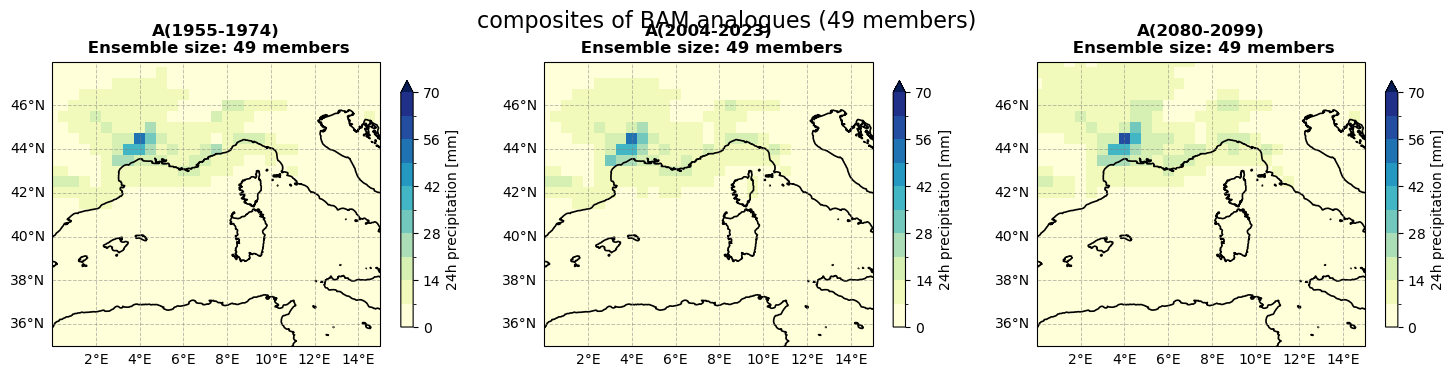

In [15]:
fig, ax = plt.subplots(
    nrows=1, ncols=no_epochs, figsize=(6*no_epochs, 4),
    sharey=True,
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot
for i in range(no_epochs):
    fanPM.plot_precipitation(
        ax[i], 
        box_event, 
        list_ds[i][varname]*factor, 
        np.arange(0, 77, 7),
        f'A({list_year_ranges[i][0]}-{list_year_ranges[i][1]})\n Ensemble size: {no_membs} members')
fig.suptitle(f'composites of BAM analogues ({no_membs} members)', fontsize=16)

# Save the figure
fig.savefig(f"{fig_dir}{varname}_analogues-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)

### Plot variable difference between different epochs and using different ensemble sizes

In [18]:
# Parameters
# Variable
varname = 'psl'
if varname == 'pr':
    factor = 3600
else:
    factor = 1

# List epochs
list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
no_epochs = len(list_year_ranges)

# Difference between epochs
list_diff_indices = [[0,1],[1,2], [0,2]]  # Define the indices of epochs to compare

# List of ensemble sizes (by no members considered)
list_size_ens = [1, 10, 49]
str_size_ens = ''
for se in list_size_ens:
    str_size_ens += f'{se}-'
str_size_ens = str_size_ens[:-1] + 'membs'
print(str_size_ens)

1-10-49membs


In [19]:
list_ds_diff = []  # List to store difference datasets
list_str_diff = []  # List to store strinlist_membs[19]g representations of differences
list_ds_ks_stats = []  # List to store KS statistics datasets
for no_membs in list_size_ens:
    for i in range(len(list_diff_indices)):
        year_range1 = list_year_ranges[list_diff_indices[i][0]]
        str_year_range1 = "-".join(str(x) for x in year_range1)
        year_range2 = list_year_ranges[list_diff_indices[i][1]]
        str_year_range2 = "-".join(str(x) for x in year_range2)
        list_str_diff.append(f'{str_year_range2} - {str_year_range1}')  # Store the string representation of the difference
        suffix_file = f"_{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_diff{str_year_range2}_{str_year_range1}_CRCM5_{no_membs}membs.nc"
            
        # Load analogue differences
        diff_file = f'{diff_dir}analogues-{var_analogues}_difference{suffix_file}'
        if not os.path.exists(diff_file):
            print(f'File {diff_file} does not exist. Skipping epoch {i+1}.')
            continue
        ds_diff = xr.open_dataset(diff_file)
        list_ds_diff.append(ds_diff)
        # Load KS statistics
        significance_file = f'{diff_dir}analogues-{var_analogues}_KS-statistics{suffix_file}'
        if not os.path.exists(significance_file):
            print(f'File {significance_file} does not exist. Skipping epoch {i+1}.')
            continue
        ds_ks_stats = xr.open_dataset(significance_file)
        list_ds_ks_stats.append(ds_ks_stats)

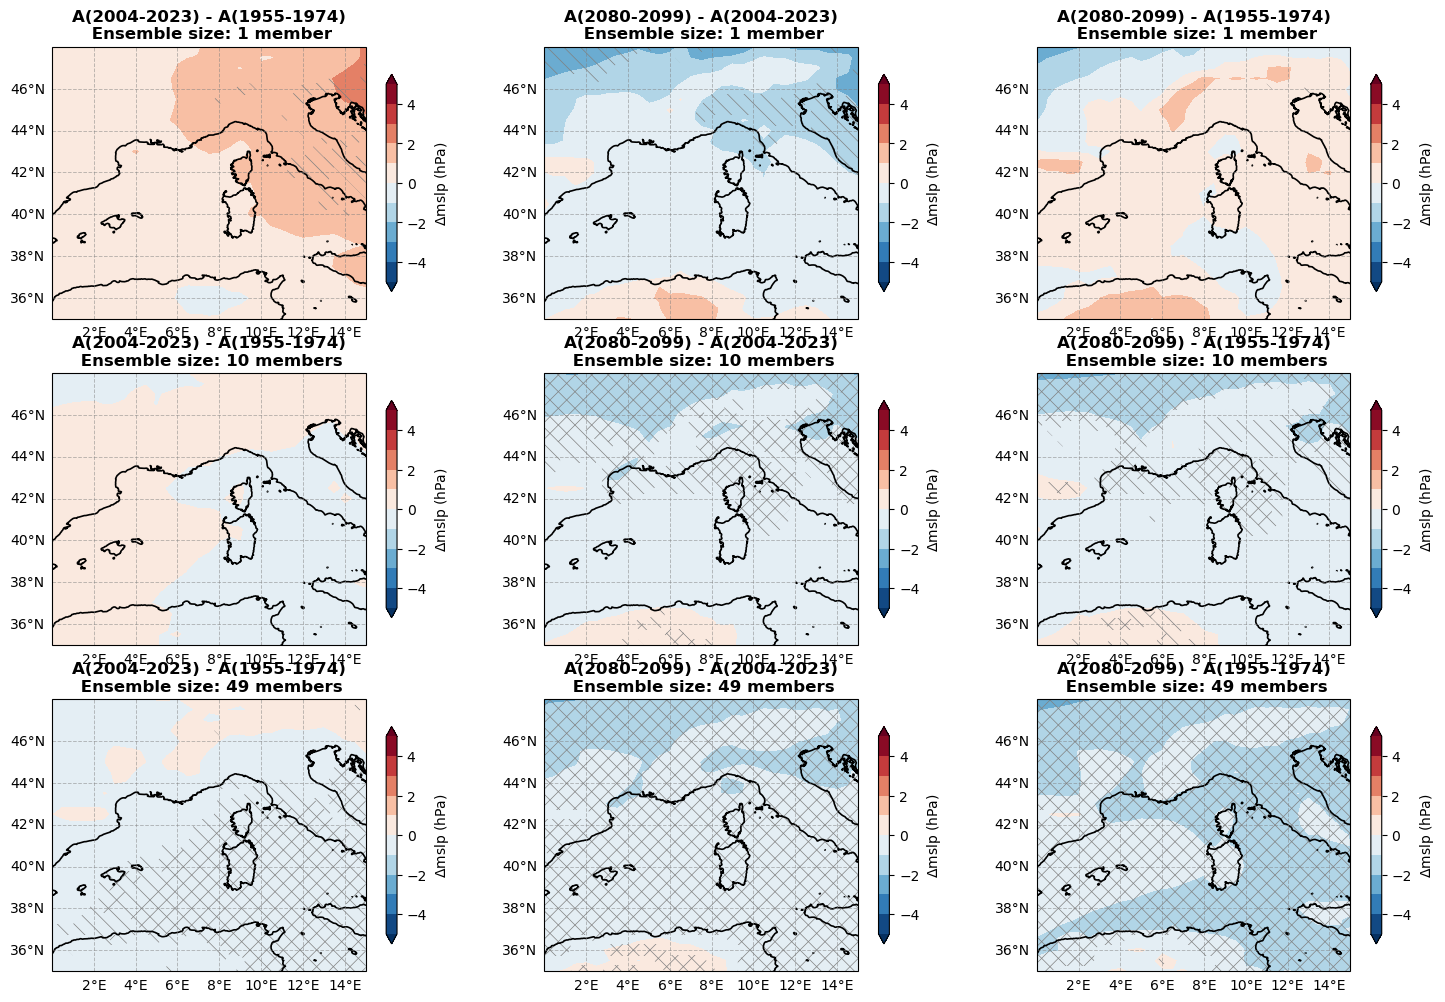

In [20]:
# Plot difference (columns of epoch differences, rows of ensemble sizes)
no_diff = len(list_diff_indices)
no_size = len(list_size_ens)
fig, ax = plt.subplots(nrows=no_size, ncols=no_diff, 
                       figsize=(no_diff * 6, no_size * 4),
                       sharex=True, sharey=True,
                       subplot_kw={'projection': ccrs.PlateCarree()}
                       )
ax = ax.ravel()

for i in range(no_size):
    for j in range(no_diff):
        k = i*no_diff + j
        # Plot the difference for each ensemble size and epoch difference
        ds_diff = list_ds_diff[k]
        ds_ks_stats = list_ds_ks_stats[k]
        p_values = ds_ks_stats.sel(output='pvalue').squeeze()[varname].values
        str_year_range1 = f"{list_year_ranges[list_diff_indices[j][0]][0]}-{list_year_ranges[list_diff_indices[j][0]][1]}"
        str_year_range2 = f"{list_year_ranges[list_diff_indices[j][1]][0]}-{list_year_ranges[list_diff_indices[j][1]][1]}"
        if list_size_ens[i]==1:
            subtitle = f'A({str_year_range2}) - A({str_year_range1})\n Ensemble size: {list_size_ens[i]} member'
        else:
            subtitle = f'A({str_year_range2}) - A({str_year_range1})\n Ensemble size: {list_size_ens[i]} members'
        if varname == 'pr':
            fanPM.plot_precipitation(ax[k], box_event, ds_diff['pr']*factor, 
                               precip_levels=np.arange(-15, 16, 2), title=subtitle)
        elif varname == 'tas':
            fanPM.plot_anom_event(ax[k], varname, ds_diff.lon, ds_diff.lat, ds_diff['tas'], ds_diff['tas']*np.nan, 
                            subtitle, levels= np.arange(-6.5, 6.75, 1))
        elif varname == 'psl':
            fanPM.plot_anom_event(ax[k], "mslp", ds_diff.lon, ds_diff.lat, ds_diff['psl'], ds_diff['psl']*np.nan, 
                            subtitle, levels= np.arange(-5, 5.1, 1))
        # 
        # Flatten while ignoring NaNs
        mask = ~np.isnan(p_values)
        pvals_flat = p_values[mask]
        # Apply FDR correction
        rejected, pvals_corrected = fdrcorrection(pvals_flat, alpha=0.05)
        # Put results back into 2D arrays, filling NaNs where appropriate
        rejected_2d = np.full(p_values.shape, np.nan)
        rejected_2d[mask] = rejected
        pvals_corrected_2d = np.full(p_values.shape, np.nan)
        pvals_corrected_2d[mask] = pvals_corrected
        # Hatching where significant
        significant_mask_corrected = pvals_corrected_2d < 0.05
        significant_mask = p_values < 0.05
        # Contour significant areas
        plt.rcParams['hatch.linewidth'] = 0.5   # thinner lines
        plt.rcParams['hatch.color'] = 'grey'
        ax[k].contourf(
            ds_diff['lon'], ds_diff['lat'], significant_mask_corrected,
            levels=[0.5, 1.5], 
            colors='none',      # no fill color
            hatches=['//'],
            transform=ccrs.PlateCarree()
        )
        ax[k].contourf(
            ds_diff['lon'], ds_diff['lat'], significant_mask,
            levels=[0.5, 1.5], 
            colors='none',      # no fill color
            hatches=['\\\\'],
            transform=ccrs.PlateCarree()
        )
fig.savefig(f"{fig_dir}{varname}_analogue-differences-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_CRCM5_{str_size_ens}.png", bbox_inches='tight', dpi=300)

#### Average precipitation in BAM >20mm mask

In [19]:
# Parameters
# Variable
varname = 'pr'
factor = 3600

# List epochs
list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
no_epochs = len(list_year_ranges)

# List of ensemble sizes (by no members considered)
list_size_ens = [1, 10, 49]
str_size_ens = ''
for se in list_size_ens:
    str_size_ens += f'{se}-'
str_size_ens = str_size_ens[:-1] + 'membs'
print(str_size_ens)

1-10-49membs


In [20]:
# BAM regional mean precipitation
BAM_info, BAM_index = fanPM.get_best_model_analogue_info(no_node, no_event, var_analogues)
mean_pr_BAM_in_mask = BAM_info['precip_in_BAM_20mm_mask'][BAM_index]

# Upload analogue data for mean precipitation in BAM mask
no_size = len(list_size_ens)
list_ds_reg = []  # List to store difference datasets
list_stats_past = []  # List to store statistics for past epochs
list_stats_future = []  # List to store statistics for future epochs
for i in range(no_size):
    no_membs = list_size_ens[i]
    for j in range(no_epochs):
        year_range = list_year_ranges[j]
        str_year_range = "-".join(str(x) for x in year_range)

        # Load analogue values
        pr_reg_epoch = None
        for im, memb in enumerate(list_membs[:no_membs]):
            file = f'{pr_mask_dir}analogues-{var_analogues}_mask-mean-{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_{str_year_range}_CRCM5_{memb}.nc'
            if not os.path.exists(file):
                print(f'File {file} does not exist. Skipping epoch {j+1}.')
                continue
            pr_reg = xr.open_dataset(file)['pr'].values
            if pr_reg_epoch is None:
                pr_reg_epoch = pr_reg
            else:
                pr_reg_epoch = np.concatenate((pr_reg_epoch, pr_reg))
        list_ds_reg.append(np.array(pr_reg_epoch))

    # Compute p-val using KS test
    arr_past = list_ds_reg[-3].flatten()
    arr_past = arr_past[~np.isnan(arr_past)]
    arr_present = list_ds_reg[-2].flatten()
    arr_present = arr_present[~np.isnan(arr_present)]
    arr_future = list_ds_reg[-1].flatten()
    arr_future = arr_future[~np.isnan(arr_future)]
    list_stats_past.append(fanPM.ks_stat_and_pval(arr_past, arr_present))
    list_stats_future.append(fanPM.ks_stat_and_pval(arr_present, arr_future))

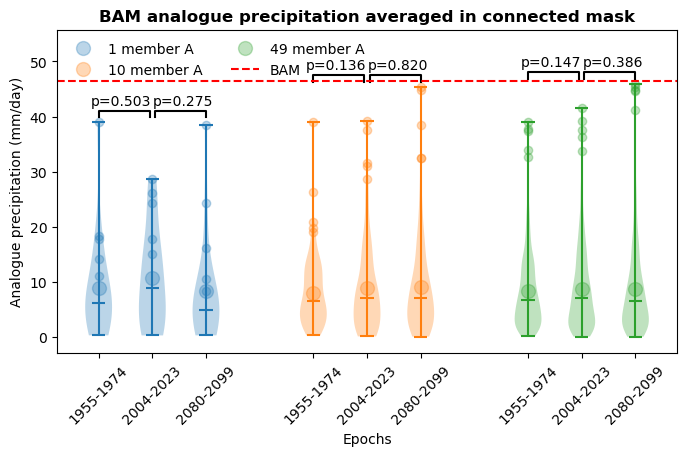

In [21]:
# Plot violin plots per epoch, once per ensemble size

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4.2))
ax.set_title(f"BAM analogue precipitation averaged in connected mask", fontsize=12, weight="bold")

# Violin plot setup
list_epoch_str = [f"{year_range[0]}-{year_range[1]}" for year_range in list_year_ranges]

for i in range(no_size):
    # Get the data for the current epoch and ensemble size
    list_reg_precip = list_ds_reg[i*no_epochs:(i+1)*no_epochs]
    # Plot the violin for the current epoch and ensemble size
    reg_precip_clean = [x[~np.isnan(x)]*factor for x in list_reg_precip]
    violin = ax.violinplot(reg_precip_clean, positions=1+i*4+np.arange(no_epochs),showmeans=False, showmedians=True, showextrema=True)
    # Plot the mean precipitation for the epoch
    violin_color = violin['bodies'][0].get_facecolor().flatten()
    no_membs = list_size_ens[i]
    plot_label = f'{no_membs} member A'
    ax.plot(1+i*4+np.arange(no_epochs), [np.mean(reg_precip_clean[j]) for j in range(len(reg_precip_clean))], marker='o', color=violin_color, markersize=10, label=plot_label, linewidth=0)
    # Plot the 5 top values as stars
    for j in range(no_epochs):
        top5_values = np.sort(reg_precip_clean[j])[-5:]
        ax.plot(np.full(top5_values.shape, 1 + i*4 + j), top5_values, marker='o', color=violin_color, markersize=6, linewidth=0)
    
    # Add p-value
    p_past = list_stats_past[i][1]
    p_future = list_stats_future[i][1]
    # Get x positions of the two violins
    x1 = 1 + i*4 + 0              # first violin position
    x2a = 1 + i*4 + 0.95              # second violin position
    x2b = 1 + i*4 + 1.05
    x3 = 1 + i*4 + 2              # third violin position
    y_max = max([np.max(reg_precip_clean[j]) for j in range(no_epochs)])  # highest point for vertical placement
    # Draw a bracket line
    ax.plot([x1, x1, x2a, x2a], [y_max*1.02, y_max*1.05, y_max*1.05, y_max*1.02], color="black")
    ax.plot([x2b, x2b, x3, x3], [y_max*1.02, y_max*1.05, y_max*1.05, y_max*1.02], color="black")
    # Add the p-value text above
    ax.text((3*x1+2*x2b)/5, y_max*1.06, f"p={p_past:.3f}", ha="center", va="bottom", fontsize=10, color="black")
    ax.text((2*x2a+3*x3)/5, y_max*1.06, f"p={p_future:.3f}", ha="center", va="bottom", fontsize=10, color="black")
# Plot the mean precipitation of the BAM event
ax.axhline(mean_pr_BAM_in_mask, color='red', linestyle='--', label='BAM')
# Ticks and labels
ax.set_xticks(range(1, no_size*(no_epochs + 1)))
list_epoch_ticks = []
xticks = []
for i in range(no_size):
    xticks.extend([1+i*4+j for j in range(no_epochs)])
    list_epoch_ticks.extend(list_epoch_str)
ax.set_ylim(-3,np.max((mean_pr_BAM_in_mask,y_max))*1.2)
ax.set_xticks(xticks)
ax.set_xticklabels(list_epoch_ticks, rotation=45)
ax.set_xlabel('Epochs')
ax.set_ylabel('Analogue precipitation (mm/day)')
ax.legend(ncol=2, frameon=False, loc='upper left') 
plt.show()

# Save the figure
fig.savefig(f"{fig_dir}{varname}_mask-mean_analogues-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_CRCM5_{str_size_ens}.png", bbox_inches='tight', dpi=300)

In [22]:
arr_allmemb = list_ds_reg[6:]
max_pr_allmemb = [np.max(arr_allmemb[j])*factor for j in range(no_epochs)]
max5_pr_allmemb = [np.sort(arr_allmemb[j].flatten())[-5:] * factor for j in range(no_epochs)]
for i in range(no_epochs):
    print(f"Max precipitation values across all members for epoch {list_year_ranges[i][0]}-{list_year_ranges[i][1]}: {max_pr_allmemb[i]:.2f} mm/day")
    print(f"Mean of top 5 max precipitation values across all members for epoch {list_year_ranges[i][0]}-{list_year_ranges[i][1]}: {np.mean(max5_pr_allmemb[i]):.2f} mm/day")
    print(f"Top 5 max precipitation values across all members for epoch {list_year_ranges[i][0]}-{list_year_ranges[i][1]}: {max5_pr_allmemb[i]} mm/day")

Max precipitation values across all members for epoch 1955-1974: 39.05 mm/day
Mean of top 5 max precipitation values across all members for epoch 1955-1974: 36.13 mm/day
Top 5 max precipitation values across all members for epoch 1955-1974: [32.645822   33.95313077 37.29983461 37.70766517 39.05455736] mm/day
Max precipitation values across all members for epoch 2004-2023: 41.63 mm/day
Mean of top 5 max precipitation values across all members for epoch 2004-2023: 37.64 mm/day
Top 5 max precipitation values across all members for epoch 2004-2023: [33.71967349 36.26247651 37.4605241  39.11410497 41.62841582] mm/day
Max precipitation values across all members for epoch 2080-2099: 45.83 mm/day
Mean of top 5 max precipitation values across all members for epoch 2080-2099: 44.35 mm/day
Top 5 max precipitation values across all members for epoch 2080-2099: [41.15990033 44.60086796 44.84813628 45.33307644 45.82823605] mm/day


### Plot BAM analogues with highest precipitation in mask

In [23]:
N_max = 5
# Identify the members corresponding to the top N_max precipitation values in the mask for each epoch
list_dict_max = [None, None, None]
for j in range(no_epochs):
    year_range = list_year_ranges[j]
    str_year_range = "-".join(str(x) for x in year_range)
    # Load analogue values
    for im, memb in enumerate(list_membs):
        file = f'{pr_mask_dir}analogues-{var_analogues}_mask-mean-{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_{str_year_range}_CRCM5_{memb}.nc'
        if not os.path.exists(file):
            print(f'File {file} does not exist. Skipping epoch {j+1}.')
            continue
        pr_reg = xr.open_dataset(file)['pr'].values.flatten()
        pr_max = np.sort(pr_reg)[-N_max:]
        pr_max_idxs = np.argsort(pr_reg)[-N_max:]
        pr_max_members = [memb] * N_max  # Current member
        if list_dict_max[j] is None:
            list_dict_max[j] = {
                'values': pr_max,
                'indices': pr_max_idxs,
                'members': pr_max_members
            }
        else:
            # Combine and keep top 5
            combined_values = np.concatenate((list_dict_max[j]['values'], pr_max))
            combined_idxs = np.concatenate((list_dict_max[j]['indices'], pr_max_idxs))
            combined_members = list_dict_max[j]['members'] + pr_max_members
            top_indices = np.argsort(combined_values)[-N_max:]
            list_dict_max[j] = {
                'values': combined_values[top_indices],
                'indices': combined_idxs[top_indices],
                'members': [combined_members[k] for k in top_indices]
            }
print(f"Top {N_max} precipitation values, with corresponding members and analogue-number for each epoch:")
for j in range(no_epochs):
    year_range = list_year_ranges[j]
    print(f"Epoch {year_range[0]}-{year_range[1]}:")
    pr_reg_max_values = list_dict_max[j]['values'] * factor
    pr_reg_max_idxs = list_dict_max[j]['indices']
    pr_reg_max_members = list_dict_max[j]['members']
    for k in range(N_max):
        print(f"  Value: {pr_reg_max_values[k]:.2f} mm/day, Member: {pr_reg_max_members[k]}, Index: {pr_reg_max_idxs[k]}")


Top 5 precipitation values, with corresponding members and analogue-number for each epoch:
Epoch 1955-1974:
  Value: 32.65 mm/day, Member: kcw, Index: 5
  Value: 33.95 mm/day, Member: kci, Index: 10
  Value: 37.30 mm/day, Member: kcf, Index: 3
  Value: 37.71 mm/day, Member: kbu, Index: 1
  Value: 39.05 mm/day, Member: kba, Index: 0
Epoch 2004-2023:
  Value: 33.72 mm/day, Member: kbv, Index: 0
  Value: 36.26 mm/day, Member: kcq, Index: 8
  Value: 37.46 mm/day, Member: kbb, Index: 11
  Value: 39.11 mm/day, Member: kbc, Index: 12
  Value: 41.63 mm/day, Member: kca, Index: 4
Epoch 2080-2099:
  Value: 41.16 mm/day, Member: kbn, Index: 1
  Value: 44.60 mm/day, Member: kbq, Index: 1
  Value: 44.85 mm/day, Member: kbd, Index: 12
  Value: 45.33 mm/day, Member: kbe, Index: 1
  Value: 45.83 mm/day, Member: kcs, Index: 4


In [24]:
# Find date of top N_max precipitation values for each epoch
for j in range(no_epochs):
    year_range = list_year_ranges[j]
    str_year_range = "-".join(str(x) for x in year_range)
    times = []
    for im, memb in enumerate(list_dict_max[j]['members']):
        idx_analogue = list_dict_max[j]['indices'][im]
        # Construct the file path
        file_path = f'./analogue_data/times_distances_analogues-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_{str_year_range}_CRCM5-LE_memb-{memb}.npz'
        # Load the .npz file
        data = np.load(file_path, allow_pickle=True)
        times.append(data['times'][idx_analogue])
    list_dict_max[j]['times'] = times


In [27]:
# Load precip
list_pr_max = []
for i in range(no_epochs):
    year_range = list_year_ranges[i]
    str_year_range = "-".join(str(x) for x in year_range)
    print(f"Loading precipitation data for epoch {str_year_range}...")
    # Get list of members and dates
    list_members = list_dict_max[i]['members']
    list_dates = list_dict_max[i]['times']

    # Load precipitation data for the selected members and dates
    precip_files = fanPM.get_precipitation_paths_CRCM5_bymonth(CRCM5_dir, list_members, [[date] for date in list_dates])
    # Make list of datasets and add 'member' coordinate
    list_ds_pr = fanPM.open_member_datasets(precip_files, combine='by_coords', expand_member_dim=True)
    # Order list from alphabetical order of member to order in BAM_members
    list_alphabetical_members = list(dict.fromkeys(sorted(list_members)))
    list_ds_pr = [list_ds_pr[list_alphabetical_members.index(member)] for member in list_members]
    
    # Select lon lat mask for the event
    ds_tmp = list_ds_pr[0]
    lon_mask, lat_mask = fanPM.lonlat_mask(ds_tmp.lon.values, ds_tmp.lat.values, box_event)
    mask_BAM = lat_mask[:, np.newaxis] & lon_mask
    mask_xr_BAM = xr.DataArray(
        mask_BAM,
        dims=["lat", "lon"],
        coords={"lat": ds_tmp.lat.values, "lon": ds_tmp.lon.values},
    )
    
    # scale, choose date and select box
    pr_max = []
    for j, ds in enumerate(list_ds_pr):
        pr_tmp = ds['pr'] * 3600 # Convert from mm/s*24 to mm/day
        pr_tmp = pr_tmp.sel(time=list_dates[j] + timedelta(hours=12))
        pr_tmp = pr_tmp.where(mask_xr_BAM, drop=True)
        pr_max.append(pr_tmp.squeeze())
    pr_max = xr.concat(pr_max, dim='member')
    list_pr_max.append(pr_max)
    

Loading precipitation data for epoch 1955-1974...
Opening files for member: kba
Opening files for member: kbu
Opening files for member: kcf
Opening files for member: kci
Opening files for member: kcw
Loading precipitation data for epoch 2004-2023...
Opening files for member: kbb
Opening files for member: kbc
Opening files for member: kbv
Opening files for member: kca
Opening files for member: kcq
Loading precipitation data for epoch 2080-2099...
Opening files for member: kbd
Opening files for member: kbe
Opening files for member: kbn
Opening files for member: kbq
Opening files for member: kcs


[array(32.64582202), array(33.9531307), array(37.29983451), array(37.70766509), array(39.05455731), array(33.71967321), array(36.26247642), array(37.46052409), array(39.11410509), array(41.62841575), array(41.15990023), array(44.60086805), array(44.84813623), array(45.33307654), array(45.828236)]


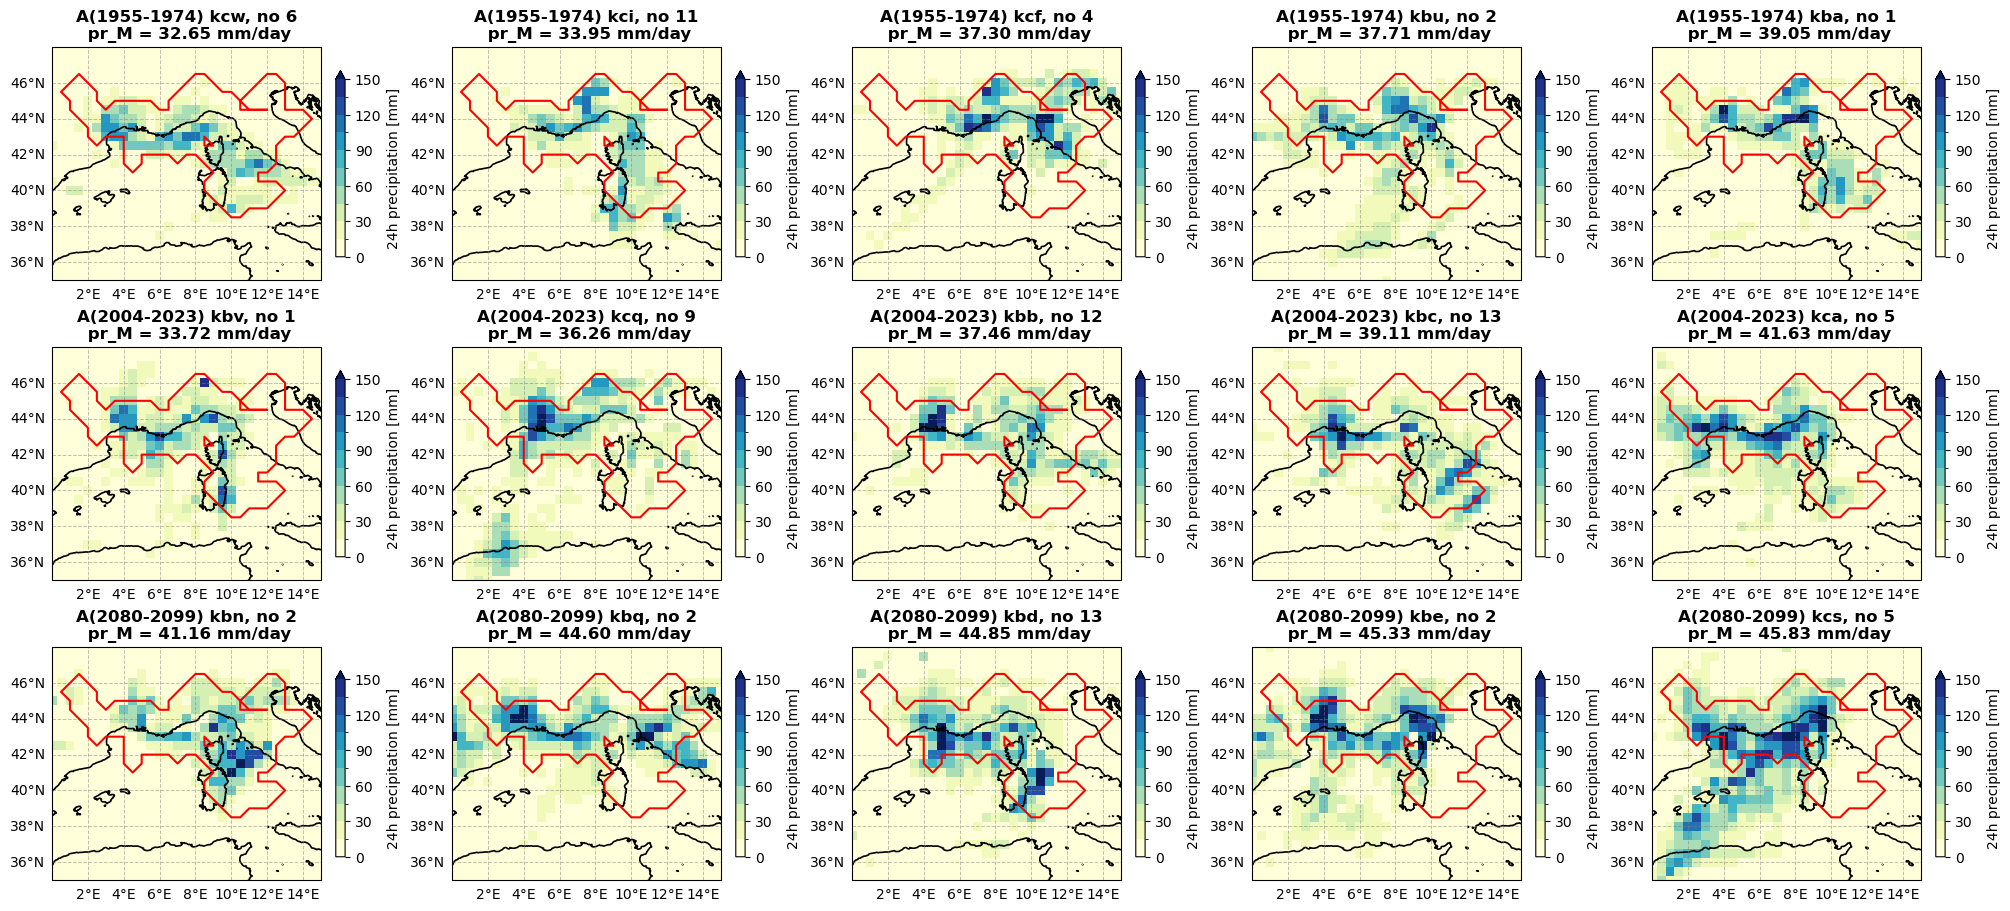

In [29]:
fig, ax = plt.subplots(
    nrows=no_epochs, ncols=N_max, figsize=(4*N_max, 3*no_epochs),
    sharey=True,
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
    )
ax = ax.ravel()

# masks
pr_mask = xr.open_dataset(f'./analogue_data/BAM_data/pr-mask_BAM-psl_{str_event_BAM}_{str_months_BAM}_2004-2023_CRCM5-LE_49membs.nc')['pr_mask']
lon = pr_mask.lon.values
lat = pr_mask.lat.values
land_mask = fanPM.create_land_mask(lon, lat).astype(int)
pr_mask_onland = pr_mask * land_mask
# weights for area average
weights = np.cos(np.deg2rad(pr_mask.lat))
weights_2d = weights.broadcast_like(pr_mask)

# Plot
pr_levels = np.arange(0, 160, 15)
list_averages = []
for j in range(no_epochs):
    year_range = list_year_ranges[j]
    str_year_range = "-".join(str(x) for x in year_range)
    for i in range(N_max):
        # compute precipitation value
        pr_reg = list_pr_max[j][i]
        pr_masked = pr_reg.where(pr_mask > 0)
        box_area_avg = (pr_masked * weights_2d).sum(dim=['lat', 'lon']) / (pr_masked.notnull() * weights_2d).sum(dim=['lat', 'lon'])
        list_averages.append(box_area_avg.values)
        # Plot
        k = j*N_max + i
        value = list_dict_max[j]['values'][i] * factor
        member = list_dict_max[j]['members'][i]
        index = list_dict_max[j]['indices'][i]
        time = list_dict_max[j]['times'][i]
        # Plot precipitation
        fanPM.plot_precipitation(
            ax[k], 
            box_event, 
            list_pr_max[j][i], 
            pr_levels,
            f'A({str_year_range}) {member}, no {index+1}\n pr_M = {value:.2f} mm/day')
        # hatch region mask
        ax[k].contour(
            pr_mask.lon, pr_mask.lat, pr_mask, 
            levels=[0], colors='red', linewidths=1.5, transform=ccrs.PlateCarree(), corner_mask=False
        )
fig.savefig(f'{fig_dir}pr-{N_max}max_analogues-{var_analogues}_{str_event_BAM}_{int(qtl_LE*100)}pct_all-epochs_CRCM5-LE_'+str(no_membs)+'membs.png')
print(list_averages)